### Описание

Даны результаты предсказания модели детекции головы котов и разметка датасета.

### Задача

Проанализировать результаты и качество предсказания модели (посчитать любые подходящие метрики) и оформить в виде презентации.

### Данные:

В папке images представлены изображения, по которым проводилась детекция

В файле ground_truth.xlsx - разметка датасета, в столбце file указано название файла с изображением, truth_label - класс объекта (0 - нет головы кота, 1 - есть голова кота), truth_bbox - бокс объекта

В файле predictions.xlsx - предсказания модели, в столбце file указано название файла с изображением, pred_label - предсказанный класс объекта (0 - нет головы кота, 1 - обнаружена голова кота), pred_bbox - предсказанный бокс объекта


Бокс объекта представляет собой прямоугольник (в данной задаче описывающий голову кота), записанный в четырех координатах: 

x, y, ширина, высота - относительно ширины и высоты изображения, где x, y - это центр прямоугольника

Например: x = абсолютная координата x / ширина изображения или высота = абсолютная высота / высота изображения
т.е. если абсолютная координата x = 50, размер изображения (200х300) - (ширина, высота), то x = 50 / 200

# Решение

Загрузим оба файла в виде pandas dataframe:

In [19]:
import pandas as pd
from ast import literal_eval

ground_truth = pd.read_excel('/home/bolshakov/work_projects/nvi/test_task/ground_truth.xlsx',
                             index_col='file')
predictions = pd.read_excel('/home/bolshakov/work_projects/nvi/test_task/predictions.xlsx',
                             index_col='file')


def transform(x):
    """
    Преобразует строковый литерал вида "[x1, y1, y1, y2]" в список.
    NaN преобразуется к пустому списку.
    
    Args: 
        x: str
    """    
    try:
        return literal_eval(str(x))   
    except Exception as e:
        return []

ground_truth['truth_bbox'] = ground_truth['truth_bbox'].apply(lambda x: transform(x))  
predictions['pred_bbox'] = predictions['pred_bbox'].apply(lambda x: transform(x))  

Для удобства дальнейшей работы объединим разметку и предсказания в один датафрейм по названию файла:

In [20]:
data = ground_truth.join(predictions)
data = data.reset_index()

assert len(data) == len(ground_truth), 'При склеивании файлов потерялись строки'

Посмотрим что получилось:

In [21]:
data.head()

,file,truth_label,truth_bbox,pred_label,pred_bbox
0,Image_AY1ZWZD5.jpg,0,[],0,[]
1,Image_B2Z6BH7R.jpg,0,[],0,[]
2,Image_YTXYC9BS.jpg,0,[],1,"[0.56886, 0.476772, 0.35424, 0.580991]"
3,Image_DBX2S91J.jpg,1,"[0.678, 0.20457, 0.4364, 0.24793]",1,"[0.63865, 0.198551, 0.4647, 0.298822]"
4,Image_CPZW8OAO.jpg,1,"[0.48533, 0.426627, 0.45522, 0.64988]",1,"[0.47552, 0.422169, 0.4088, 0.594699]"


Интереса ради отрисуем истинный и предскзанный bbox'ы на одном изображении:

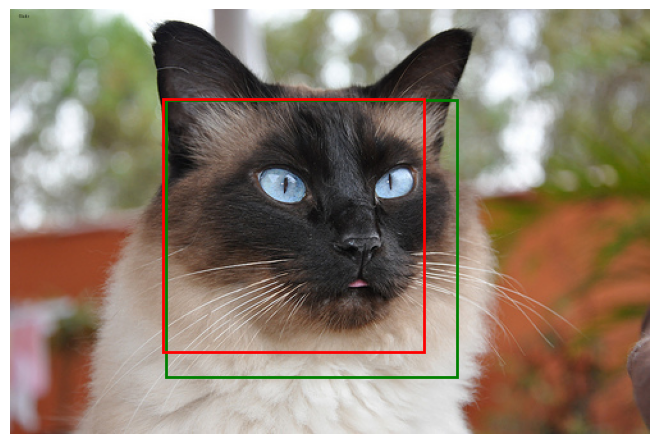

In [22]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

image = plt.imread('/home/bolshakov/work_projects/nvi/test_task/images/Image_CPZW8OAO.jpg')

h, w, _ = image.shape
fig = plt.figure()

ax = fig.add_axes([0, 0, 1, 1])
ax.axis('off')
ax.imshow(image)

truth_bbox = [0.48533, 0.426627, 0.45522, 0.64988]
pred_bbox = [0.47552, 0.422169, 0.4088, 0.594699]

rect1 = patches.Rectangle((truth_bbox[0]*w*0.5, truth_bbox[1]*h*0.5), truth_bbox[2]*w, truth_bbox[3]*h, 
                          linewidth=2, 
                          edgecolor='g', 
                          facecolor='none')

rect2 = patches.Rectangle((pred_bbox[0]*w*0.5, pred_bbox[1]*h*0.5), pred_bbox[2]*w, pred_bbox[3]*h, 
                          linewidth=2, 
                          edgecolor='r', 
                          facecolor='none')

ax.add_patch(rect1)
ax.add_patch(rect2);

Принципиальное ограничение задачи состоит в том, что нам не даны предсказанные вероятности или "confidence score" для размеченных боксов. Это делает неприменимыми или слабоприменимыми многие из имеющихся метрик, в частности мы не можем традиционным способом (упорядочивая по убыванию confidence score) построить Recall-Precision Curve

Далее я покажу, как можно поступить иначе, а пока отвлечёмся от предсказанных границ bbox'ов и посмотрим, насколько модель умеет верно детектировать само наличие/отсутствие головы кота на изображении

In [23]:
from sklearn.metrics import accuracy_score

true, pred = data['truth_label'], data['pred_label']

print(f'Accuracy: {accuracy_score(true, pred)}')

Accuracy: 0.86


In [24]:
from sklearn.metrics import precision_score, recall_score, f1_score

print(f'Presision: {precision_score(true, pred)}\nRecall: {recall_score(true, pred)}\nF1: {f1_score(true,pred):.{2}f}')

Presision: 0.8
Recall: 1.0
F1: 0.89


Уже здесь можно сделать первые выводы о качестве модели: она смогла верно выделить ВСЕ изображения, где есть коты, но её специфичность ещё можно улучшать.

Для дальнейшего анализа введём такую характеристику точности взаимного расположения bbox'ов как Intersection over Union (IoU), т.е. отношение площади пересечения к площади объединения

In [25]:
def transform_coord(bbox):
    """
    Вспомогательная функция, принимает bbox в исходном формате и 
    возвращает кортеж кооординат вида (x_min, y_min, x_max, y_max)
    
    Args: 
        bbox: list - координаты относительно центра
    """       
    cx, cy, w, h = bbox[0], bbox[1], bbox[2], bbox[3]
    x_min = cx - 0.5 * w
    y_min = cy - 0.5 * h
    x_max = cx + 0.5 * w
    y_max = cy + 0.5 * h
    return (x_min, y_min, x_max, y_max)


def intersection_over_union(boxA, boxB):
    """
    Вычисляет характеристику IoU по координатам двух bbox'ов
    Args: 
        boxA: tuple (x_min, y_min, x_max, y_max)
        boxB: tuple (x_min, y_min, x_max, y_max)
    """  
    
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    interArea = (xB - xA) * (yB - yA)

    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])

    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou

Поскольку сейчас мы хотим оценить точность выделения bbox'ов, не будем учитывать картинки, для которых истинный и предсказанный класс совпадают и равны 0.

In [26]:
data_filtered = data[data.truth_label + data.pred_label > 0]
len(data_filtered)

35

Теперь посчитаем среднее значение IoU по оставшимся изоборажениям двумя способами: с учётом изображений, где модель ошибочно поставила класс True там, где головы кота вовсе нет (тогда принимаем IoU равным 0) и без учёта таких изображений:

In [29]:
score = 0
class_match = 0

for _, row in data_filtered.iterrows():
    if row['truth_label'] == row['pred_label']:
        
        class_match += 1
        
        bboxA = transform_coord(row['truth_bbox'])
        bboxB = transform_coord(row['pred_bbox'])
        score += intersection_over_union(bboxA, bboxB)
        
print(f'Средний IoU с учётом false positive изображений: {score/len(data_filtered)}')
print(f'Средний IoU по изображениям, где правильно размечен класс True: {score/class_match}')

Средний IoU с учётом false positive изображений: 0.4402754098180057
Средний IoU по изображениям, где правильно размечен класс True: 0.5503442622725071


Наконец, воспользуемся подходом к построению Precision-Recall curve и вычислению Average Precision без использования вероятностей, описанному в https://cyberleninka.ru/article/n/obnaruzhenie-obektov-na-izobrazhenii-ot-kriteriev-bayesa-i-neymana-pirsona-k-detektoram-na-baze-neyronnyh-setey-efficientdet/viewer. В общих чертах он выглядит следующим образом:

Задается вектор пороговых значений treshold для параметра IoU. Для каждого порога находится число правильных обнаружений, соответствующее условию IoU > treshold и число ошибок первого и второго рода. Затем рассчитываются вектора точности и полноты.
Компоненты вектора полноты упорядочиваются по возрастанию (ось абсцисс) и им в соответствие ставятся значения точности (ось ординат), строится интерполированная PR-кривая, и определяется AP как площадь под ней.

In [97]:
import numpy as np

iou_range = np.arange(0.5, 0.95, 0.05)
precision = []
recall = []

for treshold in iou_range:
    tp = 0
    fp = 0
    fn = 0
    for _, row in data_filtered.iterrows():
        if row['truth_label'] != row['pred_label']:
            fn += 1
        else:
            bboxA = transform_coord(row['truth_bbox'])
            bboxB = transform_coord(row['pred_bbox'])
            iou = intersection_over_union(bboxA, bboxB)
            
            if iou > treshold: tp += 1
            else: fp += 1
        
    precision.append(tp/(tp+fp))
    recall.append(tp/(tp+fn))

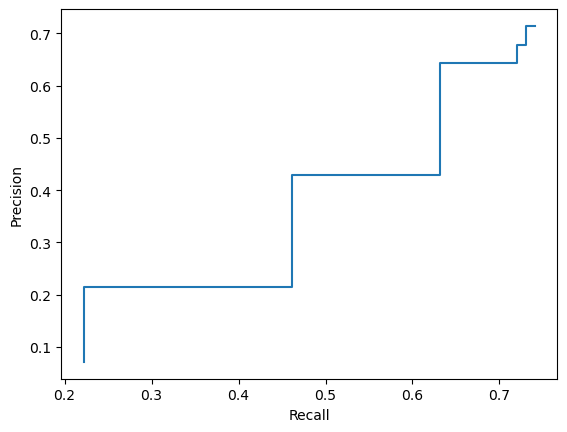

In [100]:
from sklearn.metrics import PrecisionRecallDisplay

disp = PrecisionRecallDisplay(precision, recall)
disp.plot();

Наконец, посчитаем площадь под кривой по данной метрике:

In [99]:
from sklearn.metrics import auc

auc(recall, precision)

0.15027215474583894